In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import CancerDataset_global_pooled_multi_datasets_all
from sklearn.metrics import matthews_corrcoef
import DatasetTransform_global_pooled_all
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import os
import pandas as pd
from imblearn.over_sampling import SMOTE
dir_path = os.path.dirname(os.path.abspath(os.curdir))
#Input dataset
Tr_CancerProjects=["TCGA-BRCA","TCGA-KIRC","TCGA-KIRP","TCGA-LIHC","TCGA-LUAD","TCGA-LUSC","TCGA-PRAD","TCGA-THCA","TCGA-UCEC"] ###Training and fine-tuning datasets
Te_CancerProjects=["TCGA-BLCA","TCGA-CHOL","TCGA-COAD","TCGA-ESCA","TCGA-HNSC","TCGA-KICH","TCGA-READ","TCGA-STAD"] ###Testing datasets

In [4]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork,self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(6, 12, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(24, 48, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(64, 102, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(102, 164, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(164, 256, kernel_size=(3,3), stride=1,padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.global_pool = nn.AdaptiveMaxPool2d((1,1))
        self.Lin1 = nn.Sequential(
                nn.Linear(256,120),
                nn.ReLU()
            )
        self.Lin2 = nn.Sequential(
                nn.Linear(120,64),
                nn.ReLU()
            )
        self.Lin3 = nn.Sequential(
                nn.Linear(64,32),
                nn.ReLU()
                    )
        self.Lin4 = nn.Sequential(
                nn.Linear(32,8),
                nn.ReLU()
                    )
        self.Lin5 = nn.Sequential(
                nn.Linear(8,3),
                nn.ReLU()
                    )
        self.func=nn.Softmax(dim=1)
    def forward(self,x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)
        x = self.Lin2(x)
        x = self.Lin3(x)
        x = self.Lin4(x)
        x = self.Lin5(x)
        output = self.func(x)
        return output


def calculate_accuracy_from_cm(Y_t,y_hat_class):
    cm_accuracy=accuracy_score(Y_t, y_hat_class,normalize=True)
    cm_recall=recall_score(Y_t, y_hat_class, average='weighted')
    precision=precision_score(Y_t, y_hat_class, average='weighted')
    cm_f_measure=f1_score(Y_t, y_hat_class, average='weighted')
    cm_mcc=matthews_corrcoef(Y_t,y_hat_class)
    return cm_accuracy*100, cm_recall*100, precision*100, cm_f_measure,cm_mcc

def train(model,samples):
    training_accuracy = []
    training_recall = []
    training_precision = []
    training_fmeasure = []
    training_mcc=[]
    training_loss=[]
    y_true=[]
    y_scores=[]


    print("Training started....")
    model.train()
    #size=samples
    for img, y_img in train_loader:
        img = Variable(img)
        X_t = torch.FloatTensor(img)
        
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        y_hat= model(X_t)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        
        loss = loss_func(y_hat,varr)
        training_loss.append(loss.item())
        #print(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        
        #if batch % 100 == 0:
            #loss, current = loss.item(), (batch + 1) * len(img)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        cm_accuracy, cm_recall, precision, f_measure,mcc=calculate_accuracy_from_cm(y_img.cpu().numpy(),y_hat_class.cpu().numpy())
        training_accuracy.append(cm_accuracy)
        training_recall.append(cm_recall)
        training_precision.append(precision)
        training_fmeasure.append(f_measure)
        training_loss.append(loss)
        training_mcc.append(mcc)

    return training_accuracy, training_recall,training_precision,training_fmeasure,training_mcc,training_loss

@torch.no_grad()
def valid(model,sets):
    val_accuracy = []
    val_recall = []
    val_precision = []
    val_fmeasure = []
    val_mcc=[]
    val_loss=[]


    print("Validation started....")
    for img, y_img in val_loader:
        img = Variable(img)
        X_t = torch.FloatTensor(img)
        
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        y_hat= model(X_t)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        
        loss = loss_func(y_hat,varr)
        
        val_loss.append(loss.item())
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        cm_accuracy, cm_recall, precision, f_measure,mcc=calculate_accuracy_from_cm(y_img.cpu().numpy(),y_hat_class.cpu().numpy())
        val_accuracy.append(cm_accuracy)
        val_recall.append(cm_recall)
        val_precision.append(precision)
        val_fmeasure.append(f_measure)
        val_loss.append(loss)
        val_mcc.append(mcc)

    return val_accuracy, val_recall,val_precision,val_fmeasure,val_mcc,val_loss

@torch.no_grad()
def test(model,Project):
    test_loss = []
    test_accuracy = []
    test_recall = []
    test_precision = []
    test_fmeasure = []
    test_MCC=[]
    cum_accuracy=0
    cum_precision=0
    cum_MCC=0
    labels_predict=np.array([])
    prob_predict=np.array([])
    for data in test_loader:
        img, y_img = data
        img = Variable(img)
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        X_t = torch.FloatTensor(img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        
        y_hat= model(X_t)
        #Y_t = torch.from_numpy(y_img.cpu().numpy())
        #print(y_hat)
        #print(y_img)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        #print(varr)
        loss = loss_func(y_hat,varr)

        test_loss.append(loss.item())
        
        '''y_hat =y_hat.cpu().detach().numpy()
        y_hat_class = np.where(y_hat<0.5, 0, 1)
        #print(y_hat)
        print(y_hat_class)
        labels_predict=np.append(labels_predict,y_hat_class)
        prob_predict=np.append(prob_predict,y_hat)
        y_img = y_img.cpu().detach()
        print(y_img)'''
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        y_hat_class =y_hat_class.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        
        labels_predict=np.append(labels_predict,y_hat_class)
        prob_predict=np.append(prob_predict,y_hat)
        
        y_img = y_img.cpu().detach().numpy()
        
        mcc=matthews_corrcoef(y_hat_class,y_img)
        cm_accuracy, cm_recall, precision, fmeasure,mcc =calculate_accuracy_from_cm(y_img,y_hat_class)
        print(y_img)
        print(y_hat_class)
        print(cm_accuracy)
        test_accuracy.append(cm_accuracy)
        test_recall.append(cm_recall)
        test_precision.append(precision)
        test_fmeasure.append(fmeasure)
        test_MCC.append(mcc)
    File = 'Test_predicted_labels_'+str(Project)+'.txt'
    labels_predict=labels_predict.astype(np.int)
    np.savetxt(File, labels_predict,fmt='%i')
    File = 'Test_predicted_probs_'+str(Project)+'.txt'
    np.savetxt(File, prob_predict)
    cum_accuracy=sum(test_accuracy)/len(test_accuracy)
    cum_recall=sum(test_recall)/len(test_recall)
    cum_precision=sum(test_precision)/len(test_precision)
    cum_fmeasure=sum(test_fmeasure)/len(test_fmeasure)
    cum_MCC=sum(test_MCC)/len(test_MCC)
    return cum_accuracy, cum_recall,cum_precision,cum_fmeasure,cum_MCC

In [5]:
Project='CDMPTHY_Filtered'
df = pd.read_csv(dir_path+'/datasets/'+Project+'.csv', index_col=0, header=0)
df = df.astype(np.float32)
dfl = pd.read_csv(dir_path+'/datasets/'+Project+'_label.csv', index_col=0,header=0)
dfl = dfl.astype(np.float32)

labels = dfl['label'].value_counts()
weights =[]
for i in range(len(labels)):
    weights.append(round((sum(labels)/labels[i]), 2))
weights = np.array(weights, dtype=np.float32)
weights = torch.tensor(weights).cuda()

smote = SMOTE()
X_remain, X_test, y_remain, y_test = train_test_split(df, dfl, random_state=0, test_size=0.2, stratify=dfl)
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, random_state=0, test_size=0.2, stratify=y_remain)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#Acquire the name of the genes being trained and tested after splitting
genes = X_train.index
genes =genes.to_frame()
genes.to_csv('X_train_genes.csv', index = False, header = False)
genes = X_test.index
genes =genes.to_frame()
genes.to_csv('X_test_genes.csv', index = False, header = False)

#Convert everything to numpy matrix for pytorch
#X_train = X_train_balanced.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
#y_train = y_train_balanced.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
weights

tensor([10.3600,  8.9000,  1.2600], device='cuda:0')

In [42]:
mode = 'Weighted Loss Function'
Title = 'Cardiomyopathy'

In [43]:
epoch=31
learning_rate=1e-4
np.random.seed(0)
torch.manual_seed(0)
loss_func = nn.CrossEntropyLoss(weight=weights)
performance_by_dataset=[]
auc_file=[]
model= MyNetwork()
if torch.cuda.is_available():
    model = model.cuda()

In [44]:
train_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_train,xy_label=y_train,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
test_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_test,xy_label=y_test,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
val_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_val,xy_label=y_val,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
samples=train_dataset.len
test_loader = DataLoader(dataset=test_dataset, batch_size=256)#, shuffle=True)
products=test_dataset.len
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=True)
sets=val_dataset.len

###try sk.learn resample to reduce the class imbalance

loading dataset
loading dataset
loading dataset


In [45]:
start_time = time.time()
C1_weights = []
L5_weights = []
performance_by_dataset=[]

for i in range(epoch):
    if(i>1):
        MyModelName='Model.pth'
        model.load_state_dict(torch.load(MyModelName))
        model.train()
    #torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    training_accuracy,training_recall, training_precision,training_fmeasure,training_mcc,training_loss=train(model,samples)
    accuracy=sum(training_accuracy)/len(training_accuracy)
    recall=sum(training_recall)/len(training_recall)
    precision=sum(training_precision)/len(training_precision)
    fmeasure=sum(training_fmeasure)/len(training_fmeasure)
    mcc=sum(training_mcc)/len(training_mcc)
    loss = sum(training_loss)/len(training_loss)
    j = i+1
    Train_results='Epoch '+str(j)+' Train results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
    print(Train_results)
    performance_by_dataset=np.append(performance_by_dataset,Train_results)
    if i ==0 or i ==30:
        C1weights = model.state_dict()['ConvLayer1.0.weight']
        C1Weight_results='Epoch '+str(i)+' Weight results for first convolution layer '+Project+': '+str(C1weights)
        C1_weights = np.append(C1_weights, C1Weight_results)
        L5weights = model.state_dict()['Lin5.0.weight']
        L5Weight_results='Epoch '+str(i)+' Weight results for last linear layer '+Project+': '+str(L5weights)
        L5_weights = np.append(L5_weights, L5Weight_results)

    val_accuracy,val_recall, val_precision,val_fmeasure,val_mcc,val_loss=valid(model,sets)
    accuracy=sum(val_accuracy)/len(val_accuracy)
    recall=sum(val_recall)/len(val_recall)
    precision=sum(val_precision)/len(val_precision)
    fmeasure=sum(val_fmeasure)/len(val_fmeasure)
    mcc=sum(val_mcc)/len(val_mcc)
    loss = sum(val_loss)/len(val_loss)
    j = i+1
    Val_results='Epoch '+str(j)+' Validation results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
    print(Val_results)
    performance_by_dataset=np.append(performance_by_dataset,Val_results)
    
    MyModelName='Model.pth'
    torch.save(model.state_dict(), MyModelName)


end_time = time.time()
print(end_time-start_time)
File=str(Project)+'Accuracies.txt'
np.savetxt(File, performance_by_dataset, fmt='%s')

File=str(Project)+'Train_Conv1_Weights.txt'
np.savetxt(File, C1_weights, fmt='%s')
File=str(Project)+'Train_L5_Weights.txt'
np.savetxt(File, L5_weights, fmt='%s')

Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for CDMPTHY_Filtered: accuracy: 13.139789897602396 recall: 13.139789897602396  precision: 5.2096562564264906 fmeasure: 0.046392446184649674 mcc: 0.07071165601600375 loss: tensor(1.0832, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 1 Validation results for CDMPTHY_Filtered: accuracy: 16.28489077669903 recall: 16.28489077669903  precision: 3.3929083022509694 fmeasure: 0.055818071067408805 mcc: 0.14536520056396315 loss: tensor(1.0542, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 2 Train results for CDMPTHY_Filtered: accuracy: 17.72134115884116 recall: 17.72134115884116  precision: 4.852043560334282 fmeasure: 0.06908856635455685 mcc: 0.19828119441390976 loss: tensor(1.0299, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 2 Validation results for CDMPTHY_Filtered: accuracy: 20.237192267683774 recall: 20.237192267683774  precision: 4.366387828493079 fmeasure: 0.07163479296231363 mcc: 0.22733820745959893 loss: tensor(0.9808, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 3 Train results for CDMPTHY_Filtered: accuracy: 20.26567182817183 recall: 20.26567182817183  precision: 5.017052388795843 fmeasure: 0.0771439506287829 mcc: 0.2513366821365078 loss: tensor(0.9636, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 3 Validation results for CDMPTHY_Filtered: accuracy: 20.32658633841886 recall: 20.32658633841886  precision: 4.257704082737972 fmeasure: 0.07020921189386368 mcc: 0.2400543651396479 loss: tensor(0.9224, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 4 Train results for CDMPTHY_Filtered: accuracy: 20.830731768231768 recall: 20.830731768231768  precision: 4.946373967895601 fmeasure: 0.07785275944719457 mcc: 0.25334182749953293 loss: tensor(0.9083, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 4 Validation results for CDMPTHY_Filtered: accuracy: 21.59869105409154 recall: 21.59869105409154  precision: 4.890310002321045 fmeasure: 0.07921039720912638 mcc: 0.25105607820780745 loss: tensor(0.8845, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 5 Train results for CDMPTHY_Filtered: accuracy: 20.81161026473526 recall: 20.81161026473526  precision: 5.1207289143736725 fmeasure: 0.079863882785874 mcc: 0.26430272298730134 loss: tensor(0.8902, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 5 Validation results for CDMPTHY_Filtered: accuracy: 20.438193481276006 recall: 20.438193481276006  precision: 4.4982938761294635 fmeasure: 0.07315247431533167 mcc: 0.24793360649417925 loss: tensor(0.8870, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 6 Train results for CDMPTHY_Filtered: accuracy: 20.751318993506494 recall: 20.751318993506494  precision: 5.311840534888645 fmeasure: 0.08161376028951313 mcc: 0.266869337723104 loss: tensor(0.8857, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 6 Validation results for CDMPTHY_Filtered: accuracy: 21.267120319001386 recall: 21.267120319001386  precision: 5.599317495350832 fmeasure: 0.08575538486527554 mcc: 0.26913162036249033 loss: tensor(0.8768, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 7 Train results for CDMPTHY_Filtered: accuracy: 20.80146416083916 recall: 20.80146416083916  precision: 4.787599601378371 fmeasure: 0.07671038581087046 mcc: 0.25415018566523295 loss: tensor(0.8777, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 7 Validation results for CDMPTHY_Filtered: accuracy: 20.355300797503467 recall: 20.355300797503467  precision: 4.755049474109456 fmeasure: 0.07559615073678659 mcc: 0.2522217453706038 loss: tensor(0.8802, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 8 Train results for CDMPTHY_Filtered: accuracy: 20.900974025974026 recall: 20.900974025974026  precision: 5.0131481639562026 fmeasure: 0.07880146739496313 mcc: 0.2606659638032135 loss: tensor(0.8708, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 8 Validation results for CDMPTHY_Filtered: accuracy: 20.243693654646325 recall: 20.243693654646325  precision: 6.483520076271668 fmeasure: 0.0918452783383634 mcc: 0.2953776812193428 loss: tensor(0.8951, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 9 Train results for CDMPTHY_Filtered: accuracy: 20.88634022227772 recall: 20.88634022227772  precision: 4.796721805235659 fmeasure: 0.07689397172296532 mcc: 0.2572425469035602 loss: tensor(0.8660, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 9 Validation results for CDMPTHY_Filtered: accuracy: 21.074245839112344 recall: 21.074245839112344  precision: 4.835183870686741 fmeasure: 0.07765269935987996 mcc: 0.25643438866960816 loss: tensor(0.8594, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 10 Train results for CDMPTHY_Filtered: accuracy: 20.8266343031968 recall: 20.8266343031968  precision: 4.634590209430634 fmeasure: 0.07498069939389591 mcc: 0.25225476234741967 loss: tensor(0.8554, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 10 Validation results for CDMPTHY_Filtered: accuracy: 21.405816574202497 recall: 21.405816574202497  precision: 5.354784357557061 fmeasure: 0.08373081462770438 mcc: 0.26547801973955015 loss: tensor(0.8484, device='cuda:0')
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 11 Train results for CDMPTHY_Filtered: accuracy: 43.14181911838162 recall: 43.14181911838162  precision: 52.79277548687097 fmeasure: 0.38205360746160105 mcc: 0.3973123499257247 loss: tensor(0.7961, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 11 Validation results for CDMPTHY_Filtered: accuracy: 79.92534240638004 recall: 79.92534240638004  precision: 90.44853240810801 fmeasure: 0.8234781907800918 mcc: 0.6406211454745908 loss: tensor(0.6993, device='cuda:0')
Training started....
Epoch 12 Train results for CDMPTHY_Filtered: accuracy: 83.19473495254745 recall: 83.19473495254745  precision: 91.075067079997 fmeasure: 0.850005921287929 mcc: 0.6777812815518733 loss: tensor(0.6765, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 12 Validation results for CDMPTHY_Filtered: accuracy: 87.93071688626908 recall: 87.93071688626908  precision: 92.27291057220012 fmeasure: 0.8897482529449562 mcc: 0.736903081833617 loss: tensor(0.6414, device='cuda:0'

Epoch 28 Train results for CDMPTHY_Filtered: accuracy: 90.19983922327673 recall: 90.19983922327673  precision: 93.71555763755448 fmeasure: 0.9102145846236959 mcc: 0.7835297609446835 loss: tensor(0.6144, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 28 Validation results for CDMPTHY_Filtered: accuracy: 92.55916262135922 recall: 92.55916262135922  precision: 94.38921818616049 fmeasure: 0.9298353874062634 mcc: 0.8229398772304266 loss: tensor(0.6004, device='cuda:0')
Training started....
Epoch 29 Train results for CDMPTHY_Filtered: accuracy: 88.10681505994006 recall: 88.10681505994006  precision: 92.97105704987277 fmeasure: 0.8924450960386588 mcc: 0.7512022526059876 loss: tensor(0.6258, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 29 Validation results for CDMPTHY_Filtered: accuracy: 88.93355582524272 recall: 88.93355582524272  precision: 92.25567743925544 fmeasure: 0.8973454998828128 mcc: 0.7380209574131855 loss: tensor(0.6579, device='cuda

In [46]:
performance_by_dataset=[]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
MyModelName='Model.pth'
my_model = MyNetwork()
my_model.load_state_dict(torch.load(MyModelName))
my_model.eval()
accuracy2,recall2,precision2,fmeasure2,mcc2=test(model,Project)
Test_results='DEGNext Bio test results for '+Project+': accuracy '+str(accuracy2)+' recall: '+str(recall2)+' precision:   '+str(precision2)+'  fmeasure: '+str(fmeasure2)+' mcc: ' +str(mcc2)
print(Test_results)
performance_by_dataset=np.append(performance_by_dataset,Test_results)

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [1.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

[[2.]
 [1.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

C:\Users\Jiang Loh\AppData\Local\Temp\ipykernel_65712\304546728.py:238: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_predict=labels_predict.astype(np.int)


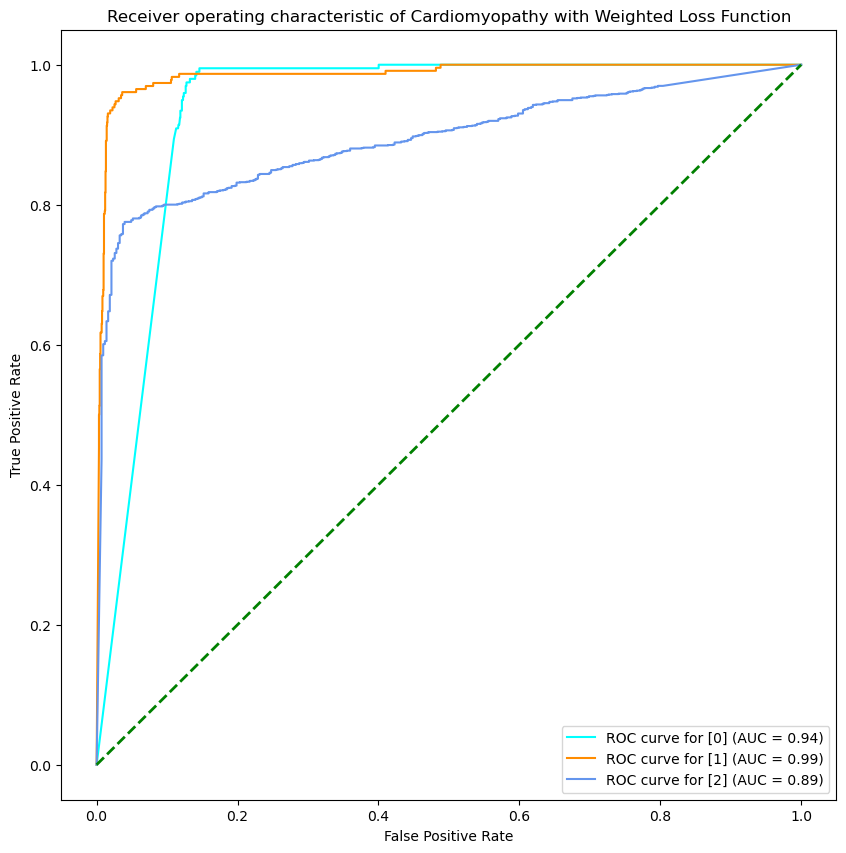

In [47]:
File = 'Test_predicted_probs_'+str(Project)+'.txt'
y_pred = np.loadtxt(File,delimiter=',', dtype=np.float32)
prob_predict3D=y_pred.reshape((-1,3))
pred_0=prob_predict3D
xy_label= y_test
y_test_b = label_binarize(xy_label, classes=[0, 1, 2])
n_classes = y_test_b.shape[1]
n_classes = 3 #for 3 classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], pred_0[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(10, 10))

colors = ["aqua", "darkorange", "cornflowerblue"]
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_b[:, class_id],
        pred_0[:, class_id],
        name=f"ROC curve for {[class_id]}",
        color=color,
        ax=ax,
    ) 
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.title('Receiver operating characteristic of '+Title+' with '+mode)
plt.savefig(Title+'_'+mode+'_ROC_comparison.png')

In [48]:
y_true=y_test
y_pred=y_pred
y_pred
#disp=ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
#disp.plot()
#plt.show()

array([9.8480398e-17, 1.7070198e-40, 1.0000000e+00, ..., 4.0723076e-05,
       1.6874972e-03, 9.9827182e-01], dtype=float32)

In [49]:
pred_0

array([[9.8480398e-17, 1.7070198e-40, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [3.7737188e-06, 3.1913000e-20, 9.9999619e-01],
       ...,
       [1.1240388e-07, 9.9973100e-01, 2.6891139e-04],
       [6.2450468e-08, 9.9999988e-01, 6.2450468e-08],
       [4.0723076e-05, 1.6874972e-03, 9.9827182e-01]], dtype=float32)

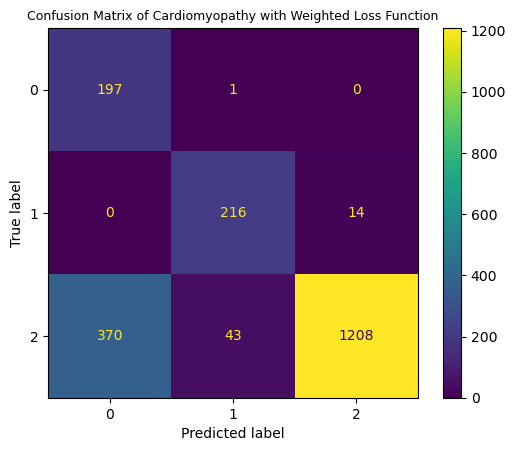

In [50]:
File = 'Test_predicted_labels_'+str(Project)+'.txt'
y_pred = np.loadtxt(File,delimiter=',', dtype=np.float32)
disp=ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()
plt.title('Confusion Matrix of '+Title+' with '+mode, fontsize=9)
plt.savefig(Title+'_'+mode+'_Confusion_Matrix.png')

In [17]:
y_true

array([[2.],
       [0.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]], dtype=float32)